In [3]:
#Import Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
sns.set_style('darkgrid')
import time
import yfinance as yf

We are going to create two portfolios. The first portfolio will contain ETFs corresponding to differnt sectors. We will add Industrial Select Sector SPDR Fund(XLI), iShares U.S. Utilities ETF (IDU), The Consumer Staples Select Sector SPDR Fund (XLP), and iShares U.S. Financials ETF (IYF) in the first portfolio. The idea is to make the volitility of the portfolio as small as we can. By combining these four ETFs, we wanto to create a portfolio with a mechanism for navigating different phases of the economic cycle. During economic expansions, the cyclical components (XLI and IYF) are likely to outperform, capturing the upside of a growing economy. Conversely, during economic contractions or periods of uncertainty, the defensive holdings (IDU and XLP) can help to mitigate losses and provide a steadying influence.

In [4]:
#load data for ETF data
tickers = ["XLI", "IDU", "XLP", "IYF"]

start_date = dt.datetime.today() - dt.timedelta(days = 5*(365)) # ETF data for last 5 Years
end_date = dt.datetime.today()

stock = yf.download(tickers, start = start_date, end = end_date)
stock.head()

/tmp/ipython-input-4-111575435.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(tickers, start = start_date, end = end_date)
[*********************100%***********************]  4 of 4 completed


Price           Close                                        High             \
Ticker            IDU        IYF        XLI        XLP        IDU        IYF   
Date                                                                           
2020-06-29  61.396877  50.088745  63.250324  51.071571  61.396877  50.231749   
2020-06-30  61.665165  50.808388  63.611439  51.448841  61.898278  51.048270   
2020-07-01  63.033073  50.748413  63.324398  51.492710  63.270589  51.269689   
2020-07-02  63.143017  50.794548  63.870716  51.755928  63.741196  51.920139   
2020-07-06  62.426083  51.463436  64.787369  52.010357  63.736802  51.957035   

Price                                   Low                                   \
Ticker            XLI        XLP        IDU        IYF        XLI        XLP   
Date                                                                           
2020-06-29  63.250324  51.168082  60.050976  49.465981  61.750321  50.404773   
2020-06-30  63.972551  51.641863  61.036201  49.964195  62.583655  51.001385   
2020-07-01  64.759593  51.817339  61.581609  50.526984  63.268844  51.466390   
2020-07-02  64.815162  52.264800  62.989078  50.702288  63.713302  51.650641   
2020-07-06  65.129959  52.273570  61.937870  51.311207  64.315142  51.720827   

Price            Open                                   Volume          \
Ticker            IDU        IYF        XLI        XLP     IDU     IYF   
Date                                                                     
2020-06-29  60.574384  49.871930  62.148472  50.448641   67600  437800   
2020-06-30  61.278113  49.964195  62.768845  51.080348   59200  303600   
2020-07-01  61.581609  51.029811  64.241067  51.545353  339200  328800   
2020-07-02  63.591653  51.809423  64.342936  51.922627   68000  404200   
2020-07-06  63.336549  51.763287  64.861445  52.150736   57600  333000   

Price                           
Ticker           XLI       XLP  
Date                            
2020-06-29  10864700   9654200  
2020-06-30   8868500   7379800  
2020-07-01   9789000   7261600  
2020-07-02   8279800   6857200  
2020-07-06  10815400  10091300

We choose the data for last $5$ years because in this time we have seen a small period of economic recession and growth in the economy. So this period of time can be a good example to test the growth of the portfolio in this phase.

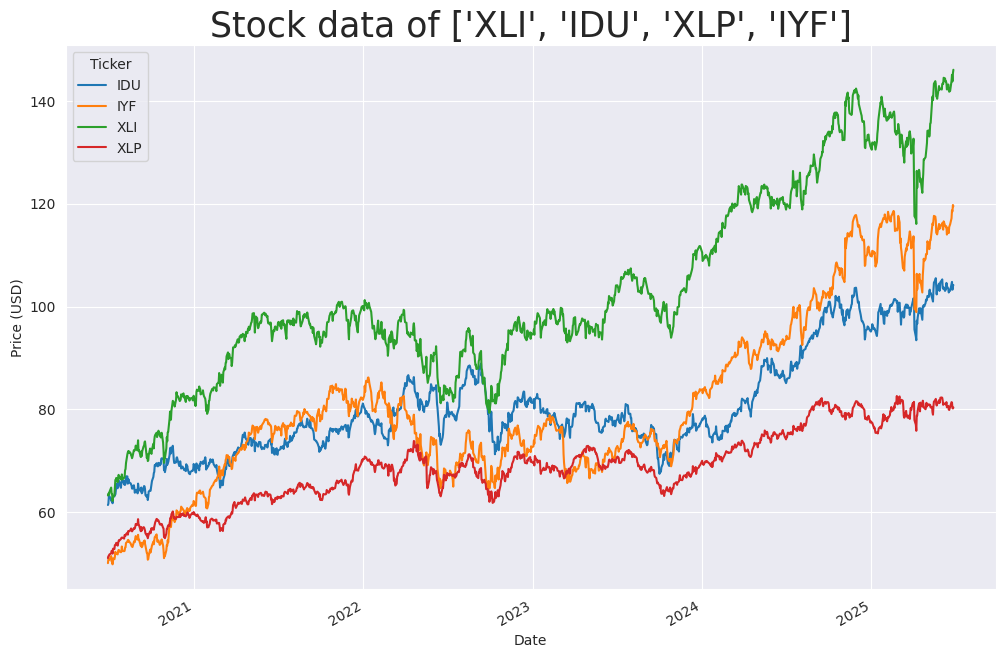

In [6]:
#Plot Closing Price of portfolio data
stock['Close'].plot(figsize = (12,8))
plt.title(f'Stock data of {tickers}', size = 25)
plt.ylabel('Price (USD)')
plt.show()

In [7]:
#Compute cumulative return from 'Close' prices
close = stock['Close']
normalized_returns = close/close.iloc[0]-1 #Moves stock prices to a start of 0


# Create columns for new data
normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])

#Concatenate to the original DataFrame
stock = pd.concat([stock, normalized_returns], axis =1 )

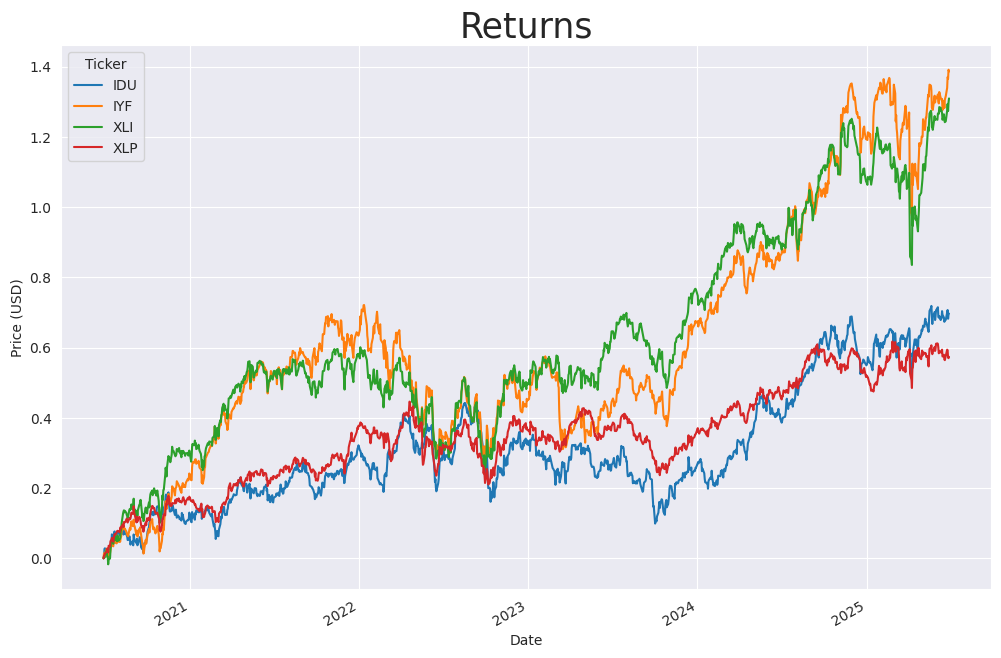

In [8]:
#Plot Cumlative Returns together
stock['Cumulative Return'].plot(figsize = (12,8))
plt.title(f'Returns', size = 25)
plt.ylabel('Price (USD)')
plt.show()


In [9]:
print('Typical method of finding volatility is to find the (log) daily returns take standard deviation and then multiply by sqrt(252) to give the yearly volatility.')

Typical method of finding volatility is to find the (log) daily returns take standard deviation and then multiply by sqrt(252) to give the yearly volatility.


In [10]:
#Create a dataframe of daily returns
#It is quite common to take the logs of daily returns to lessen computational complexity in standard deviation
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()



#Create a dictionary of standard deviations of daily return
#Normalize the standard deviation for yearly by multiplying by sqrt(#trading days in year ~ 252)
annualized_volatility = {ticker: np.std(daily_returns[ticker])*np.sqrt(252) for ticker in tickers}


In [11]:
annualized_volatility

{'XLI': np.float64(0.17929136548289196),
 'IDU': np.float64(0.16972989812876638),
 'XLP': np.float64(0.13209544911734827),
 'IYF': np.float64(0.19641613852412448)}

In [12]:
# Calculate the covariance matrix
covariance_matrix = 252*((daily_returns).cov())

In [13]:
covariance_matrix

Ticker,IDU,IYF,XLI,XLP
Ticker,,,,
IDU,0.028831,0.017005,0.016625,0.014659
IYF,0.017005,0.038610,0.030442,0.014190
XLI,0.016625,0.030442,0.032171,0.013885
XLP,0.014659,0.014190,0.013885,0.017463


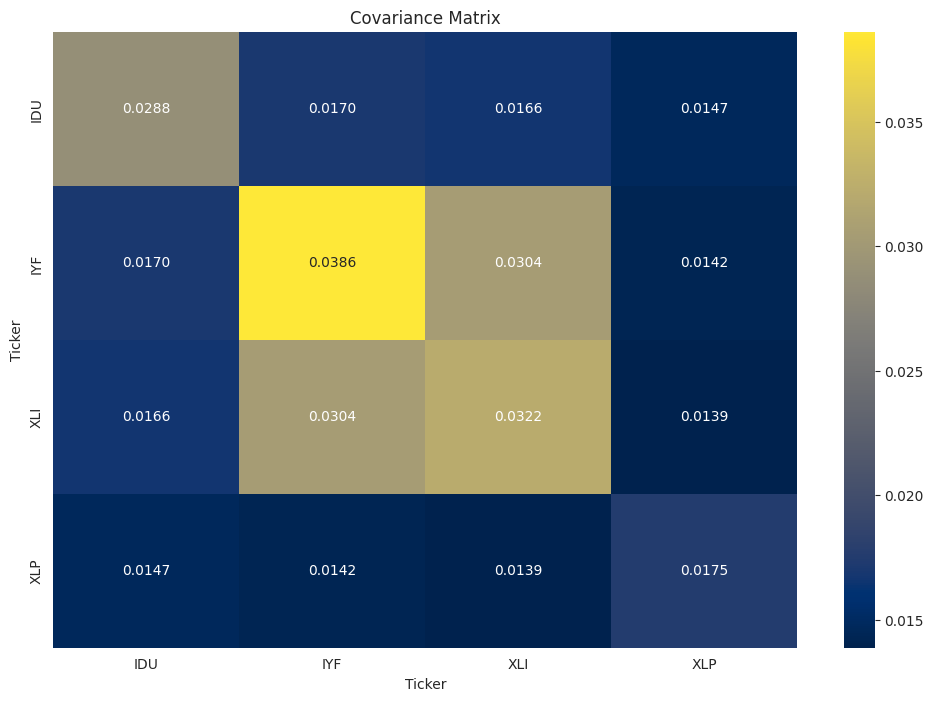

In [14]:
# Create a heatmap to visualize the covariance matrix
plt.figure(figsize = (12,8))
sns.heatmap(covariance_matrix, annot=True, cmap='cividis', fmt ='.4f')
plt.title('Covariance Matrix')
plt.show()

In [15]:
#Find a set of weights, equivalently portfolio investment percentages in stock_symbols,
#which minimizes a historical portfolio's volatility subject to the following investment constraints
#1) Must invest at least 10% of capital into each index
#2) Cannot invest more than 35% of capital into a single index

#Create dictionary average/expected daily return for indexes in stock_symbols normalized for yearly return
#expected_returns = {stock: 252*np.mean(returns[stock]) for stock in stock_symbols}


# Number of assets
n_assets = len(tickers)

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.array([1/n_assets] * n_assets)

# Define weight constraints
#Sum of weights equals 1
#Allocate at least 3% of capital into each index in stock_symbols
#Do not allocate more than 35% of capital into each index in stock_symbol
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
               {'type': 'ineq', 'fun': lambda weights: min(weights)-.1},
              {'type': 'ineq', 'fun': lambda weights: .40-max(weights)})

# Define the objective function to minimize portfolio variance
def portfolio_volatility(weights):
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portfolio_std_dev

# Run the optimization to find the optimal weights
result = minimize(portfolio_volatility, initial_weights, constraints=constraints)

# Optimal asset weights
optimal_weights = result.x

# Print the optimal weights and expected returns
print("Optimal Asset Weights to minimize volatility:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")

Optimal Asset Weights to minimize volatility:
XLI: Weight = 0.3170
IDU: Weight = 0.1000
XLP: Weight = 0.1830
IYF: Weight = 0.4000


In [16]:
print(f' The optimal volatility subject to the constraints is {result.fun}')

 The optimal volatility subject to the constraints is 0.1347650076298263


In [17]:
annualized_volatility

{'XLI': np.float64(0.17929136548289196),
 'IDU': np.float64(0.16972989812876638),
 'XLP': np.float64(0.13209544911734827),
 'IYF': np.float64(0.19641613852412448)}

# High Risk Portfolio

Now, let's consider a portfolio that is much less diversified than our first one. In this case, all the included stocks belong to the same sector. Therefore, during an economic downturn when the economy shrinks, people are less able to spend on items like technological equipment. As a result, the stock prices of technology companies will likely drop. Consequently, we are likely to observe more volatility in this portfolio compared to the first.

In [21]:
#load data for stocks
tickers = ["AAPL", "TSLA", "AMZN", "GOOD"]

start_date = dt.datetime.today() - dt.timedelta(days = 5*(365))
end_date = dt.datetime.today()

stock = yf.download(tickers, start = start_date, end = end_date)
stock.head()

/tmp/ipython-input-21-1214257128.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(tickers, start = start_date, end = end_date)
[*********************100%***********************]  4 of 4 completed


Price           Close                                         High  \
Ticker           AAPL        AMZN       GOOD       TSLA       AAPL   
Date                                                                 
2020-06-29  87.918800  134.018997  12.449597  67.290001  88.013581   
2020-06-30  88.652702  137.940994  12.549992  71.987335  88.939468   
2020-07-01  88.485016  143.934998  12.563382  74.641998  89.274822   
2020-07-02  88.485016  144.514999  12.436207  80.577332  90.030610   
2020-07-06  90.851997  152.852005  12.523223  91.438667  91.321019   

Price                                               Low              \
Ticker            AMZN       GOOD       TSLA       AAPL        AMZN   
Date                                                                  
2020-06-29  134.839996  12.657090  67.333336  85.367119  131.503998   
2020-06-30  138.481506  12.737405  72.512665  87.486222  133.751495   
2020-07-01  144.750000  12.790955  75.688667  88.436417  137.699997   
2020-07-02  147.778000  12.844500  81.866669  88.370805  143.554993   
2020-07-06  152.994003  12.757490  91.852669  89.884786  146.500000   

Price                                  Open                                    \
Ticker           GOOD       TSLA       AAPL        AMZN       GOOD       TSLA   
Date                                                                            
2020-06-29  12.255490  63.234669  85.845863  134.500504  12.375970  64.600670   
2020-06-30  12.362578  66.915337  87.505660  134.253494  12.503139  67.099998   
2020-07-01  12.429515  72.033333  88.730466  137.899506  12.556689  72.199997   
2020-07-02  12.355886  79.040001  89.393906  145.600494  12.824420  81.431999   
2020-07-06  12.362583  84.402664  89.916380  146.748505  12.717330  85.112663   

Price          Volume                                
Ticker           AAPL       AMZN    GOOD       TSLA  
Date                                                 
2020-06-29  130646000   84468000  148100  135396000  
2020-06-30  140223200   75394000  128300  253777500  
2020-07-01  110737200  127268000  130700  199903500  
2020-07-02  114041600  131868000  120100  258751500  
2020-07-06  118655600  137612000  139400  308548500

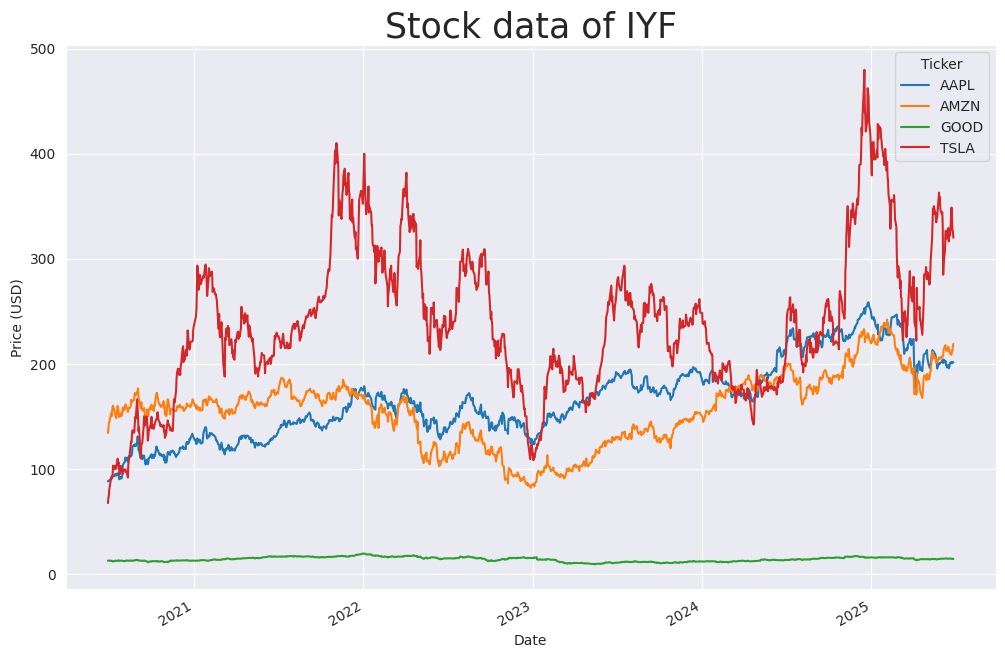

In [23]:
#Plot Closing Price of stock data
stock['Close'].plot(figsize = (12,8))
plt.title(f'Stock data of {ticker}', size = 25)
plt.ylabel('Price (USD)')
plt.show()

In [25]:
# Compute cumulative return from 'Close' prices
close = stock['Close']
normalized_returns = close/close.iloc[0]-1 #Moves stock prices to a start of 0


# Create columns for new data
normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])

# Concatenate to the original DataFrame
stock = pd.concat([stock, normalized_returns], axis =1 )

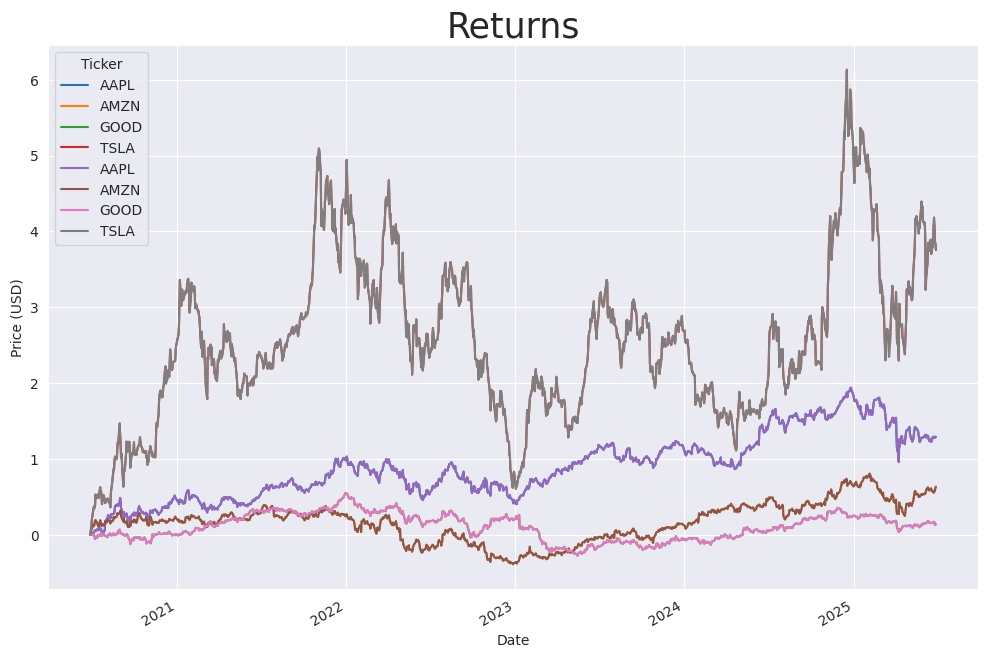

In [26]:
#Plot Cumlative Returns together
stock['Cumulative Return'].plot(figsize = (12,8))
plt.title(f'Returns', size = 25)
plt.ylabel('Price (USD)')
plt.show()


In [27]:
#Create a dataframe of daily returns
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()



#Create a dictionary of standard deviations of daily return
#Normalize the standard deviation for yearly by multiplying by sqrt(#trading days in year ~ 252)
annualized_volatility = {ticker: np.std(daily_returns[ticker])*np.sqrt(252) for ticker in tickers}


In [28]:
annualized_volatility

{'AAPL': np.float64(0.29734472155250075),
 'TSLA': np.float64(0.6406227337667849),
 'AMZN': np.float64(0.3568071587057501),
 'GOOD': np.float64(0.25745484207876124)}

In [29]:
# Calculate the covariance matrix
covariance_matrix = 252*((daily_returns).cov())

In [30]:
covariance_matrix

Ticker,AAPL,AMZN,GOOD,TSLA
Ticker,,,,
AAPL,0.088484,0.063079,0.022342,0.095657
AMZN,0.063079,0.127413,0.021797,0.104430
GOOD,0.022342,0.021797,0.066336,0.037386
TSLA,0.095657,0.104430,0.037386,0.410725


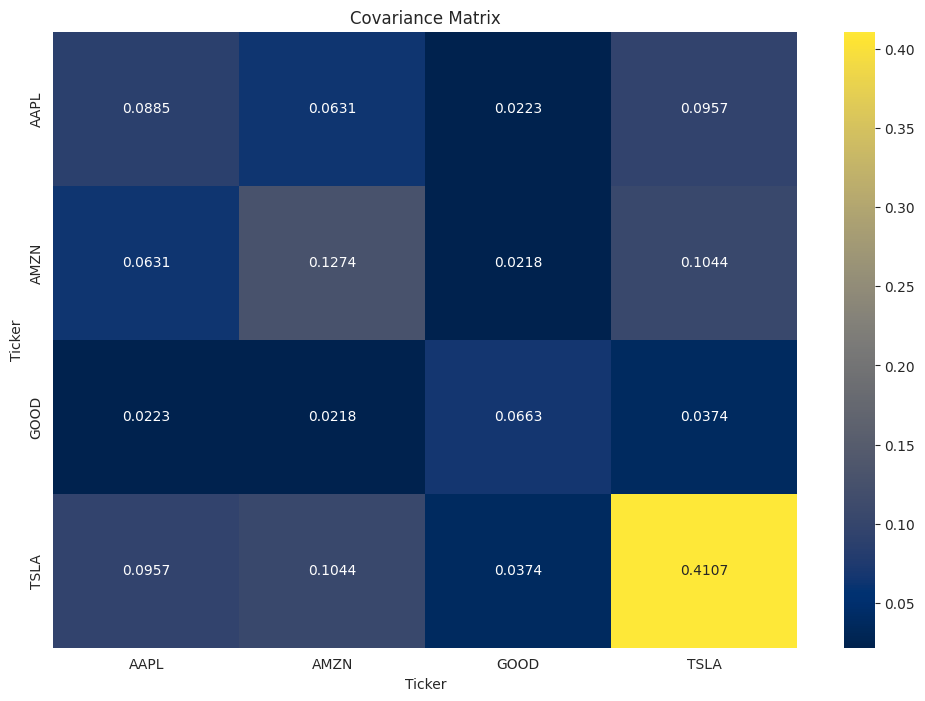

In [31]:
# Create a heatmap to visualize the covariance matrix
plt.figure(figsize = (12,8))
sns.heatmap(covariance_matrix, annot=True, cmap='cividis', fmt ='.4f')
plt.title('Covariance Matrix')
plt.show()

In [32]:
#Find a set of weights, equivalently portfolio investment percentages in stock_symbols,
#which minimizes a historical portfolio's volatility subject to the following investment constraints
#1) Must invest at least 10% of capital into each index
#2) Cannot invest more than 35% of capital into a single index

#Create dictionary average/expected daily return for indexes in stock_symbols normalized for yearly return
#expected_returns = {stock: 252*np.mean(returns[stock]) for stock in stock_symbols}


# Number of assets
n_assets = len(tickers)

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.array([1/n_assets] * n_assets)

# Define weight constraints
#Sum of weights equals 1
#Allocate at least 3% of capital into each index in stock_symbols
#Do not allocate more than 35% of capital into each index in stock_symbol
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
               {'type': 'ineq', 'fun': lambda weights: min(weights)-.1},
              {'type': 'ineq', 'fun': lambda weights: .40-max(weights)})

# Define the objective function to minimize portfolio variance
def portfolio_volatility(weights):
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portfolio_std_dev

# Run the optimization to find the optimal weights
result = minimize(portfolio_volatility, initial_weights, constraints=constraints)

# Optimal asset weights
optimal_weights = result.x

# Print the optimal weights and expected returns
print("Optimal Asset Weights to minimize volatility:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")

Optimal Asset Weights to minimize volatility:
AAPL: Weight = 0.3659
TSLA: Weight = 0.1341
AMZN: Weight = 0.4000
GOOD: Weight = 0.1000


In [33]:
print(f' The optimal volatility subject to the constraints is {result.fun}')

 The optimal volatility subject to the constraints is 0.23815794743975088


In [34]:
annualized_volatility

{'AAPL': np.float64(0.29734472155250075),
 'TSLA': np.float64(0.6406227337667849),
 'AMZN': np.float64(0.3568071587057501),
 'GOOD': np.float64(0.25745484207876124)}

In the first portfolio we observed a volitility of $13.47\%$ and in the second portfolio we observed a volitility of $23.78\%$. Our strategy of diversifying out portfolio and navigating through different sectors in an economic cycle works.